# Toward a more realistic model - adding receptors

Why LIF network are useful? What can we model with them? (Find some examples of papers using a LIF model) 


What can we do to have a more realistic network? 
How can we constrain the parameters? (Are biological experimental data available?) \
Discuss these questions togheter and try to answer them.

In [1]:
#Answers:

One possible step is to add receptors type to the LIF neuron.
The neurons have GABA (for inhibitory synapses) and AMPA (for excitatory synapses). The time constants of the two are different. We can include these differences in the model and make it more biologically plausible. 


Let's build this more complex LIF neuron.

First some theory:

A membrane equation and a reset condition define our leaky-integrate-and-fire (LIF) neuron:

$$τ_m\frac{d}{dt}V(t)=Vr−V(t)+RI(t) \  \ \ \  \  \  \text{if} \ V(t)≤ V_{th} \\
V(t)=V_{reset} \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ \text{otherwise} $$

Remebering that $R=τ_m/C_m$ and $g_L= 1/R$
We can rewrite the equation:
$$C_m\frac{d}{dt}V(t)=-g_L(V(t)-V_r)-I_{syn}(t)$$
where $I_{syn}(t)$ represents the total synaptic current flowing into the
cell.

If each neuron has AMPA GABA and NMDA receptor then 

The total synaptic currents are given by

$I_{syn}(t)= I_{ext,AMPA}(t) + I_{rec,AMPA}(t) + I_{rec,NMDA}(t) + I_{rec,GABA}(t)$
and each receptor is governed by its own equation, it integrates the spikes arriving to him whit its own time constant and dynamical behaviour. (Here more details on each equation: http://amygdala.psychdept.arizona.edu/Jclub/Wang-decision-making-2002.pdf)

With this overview let's implement a network of two populations where the neurons have these different receptor types. 

In [2]:
from brian2 import *
import numpy
import time
import statistics
import matplotlib.pyplot as plt

INFO       Cache size for target "cython": 25547 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/giulia/.cython/brian_extensions" directory. [brian2]


Here we are using Brian, another open source simulator for spiking neural networks (like Nest). 
It is written in the Python programming language. It allows some more freedom to write our equations for GABA, AMPA and NNMDA receptors.

In [3]:
#pip install brian2

In [4]:
#Parameters of the LIF neuron
Vth= -55*mV
Vrest= -70*mV
V_L = Vrest
tau_ref= 2* ms
NE=100 # number of excitatory neuron
NI=100 # number of inhibitory neuron

#Parameters for the equation of the neuron 
#(Inhibitory and excitatory neurons have different parameters)
g_m_E = 25. * nS
C_m_E = 0.5 * nF
g_m_I = 20. * nS
C_m_I = 0.2 * nF


#parameters in the equations of I_ampa, I_gaba, I_nmda (see paper)
g_AMPA_rec_I = 1.0 * nS
g_AMPA_ext_I = 1.0 *nS
g_GABA_I= 0.973 * nS

g_AMPA_rec_E = 1.0 * nS
g_AMPA_ext_E = 1.0 *nS
g_GABA_E= 0.973 * nS

g_NMDA_E = 1.0 * nS 
g_NMDA_I = 1.0 * nS 

#Reversal potential for excitatory and inhibitory (see paper)
V_E= 0. *mV
V_I = -70. * mV

#Time constant of the receptors
tau_AMPA= 2 *ms
tau_GABA= 5 *ms
tau_NMDA_rise = 2. * ms
tau_NMDA_decay = 100. * ms
#parameters we need for nmda receptors
alpha_NMDA = 0.5 / ms
Mg2 = 1.

t1=500 #ms

Now we write the equations for the LIF neuron.
Try to write the equations of dv/dt yourself by looking at the paper.

In [5]:
#Answer:
# eqsE='''
#     dv / dt =
#     I_syn=
    
#     I_AMPA_ext=
#     ds_AMPA_ext / dt = 
        
#     '''

In [6]:
#Solution: (they only needed to fill some of the equations not all of them):

In [7]:
eqsE='''

    dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)
    I_syn = I_AMPA_rec + I_AMPA_ext + I_GABA + I_NMDA: amp 
   
    I_AMPA_ext= g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
    ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
    #Here I don't need the summed variable because the neuron receive inputs from only one Poisson generator. Each neuron need only one s.
        
    
    I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA_tot : amp
    s_AMPA_tot : 1  #the eqs_ampa solve many s and sum them and give the summed value here
    #Each neuron receives inputs from many neurons. Each of them has his own differential equation s_AMPA (where I have the deltas with the spikes). 
    #I then sum all the solutions s of the differential equations and I obtain s_AMPA_tot_post.
 
    I_GABA= g_GABA_E * (v - V_I) * s_GABA_tot : amp
    s_GABA_tot :1
     
     
    I_NMDA  = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
    s_NMDA_tot : 1
     
 '''

eqsI='''

    dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)
    I_syn = I_AMPA_rec + I_AMPA_ext + I_GABA + I_NMDA : amp
    
    I_AMPA_ext= g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
    ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
    # Here I don't need the summed variable because the neuron receive inputs from only one Poisson generator. Each neuron need only one s.
        
    
    I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA_tot : amp
    s_AMPA_tot : 1  #the eqs_ampa solve many s and sum them and give the summed value here
    #Each neuron receives inputs from many neurons. Each of them has his own differential equation s_AMPA (where I have the deltas with the spikes). 
    #I then sum all the solutions s of the differential equations and I obtain s_AMPA_tot_post.
 
     I_GABA= g_GABA_I * (v - V_I) * s_GABA_tot : amp
     s_GABA_tot :1
     
     
     I_NMDA  = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
     s_NMDA_tot : 1
    
     '''

eqs_ampa='''
          s_AMPA_tot_post= w_AMPA* s_AMPA : 1 (summed)  
          ds_AMPA / dt = - s_AMPA / tau_AMPA : 1 (clock-driven)
          w_AMPA: 1
        '''

eqs_gaba='''
        s_GABA_tot_post= w_GABA* s_GABA : 1 (summed)  
        ds_GABA/ dt = - s_GABA/ tau_GABA : 1 (clock-driven)
        w_GABA: 1
        '''

eqs_nmda='''s_NMDA_tot_post = w_NMDA * s_NMDA : 1 (summed)
            ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha_NMDA * x * (1 - s_NMDA) : 1 (clock-driven)
            dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
            w_NMDA : 1
         '''

Try to understand the code, you will need to modify it later. Ask for help if something is not clear!

In [24]:
#Create the two population with the corresponfing equations:
popE = NeuronGroup(NE, model=eqsE, threshold='v > Vth', reset='v = Vrest', refractory=tau_ref, method='euler')
popI= NeuronGroup(NI, model=eqsI, threshold='v > Vth', reset='v = Vrest', refractory=tau_ref, method='euler')
#popE contains NE LIF neurons
#popI contains NI LIF neurons


#Set the initial value of the potential v for all the neurons
for k in range(0,NE):
    popE[k].v[0]=Vrest

for k in range(0,NI):
    popI[k].v[0]=Vrest


#EXCITATORY CONNECTIONS:
#Connect the neurons of popE with the neurons of popI (for the ampa connections)
conn= Synapses(popE,popI,model=eqs_ampa,on_pre='s_AMPA+=1', method='euler') #When a spike arrives the variable of the receptor is updated.
conn.connect() #all to all connections
conn.w_AMPA= 1.0 # set the weight of each synapse (wj in the paper)

#Connect the neurons of popE with the neurons of popI (for the NMDA connections)
conn1= Synapses(popE,popI,model=eqs_nmda,on_pre='x+=1', method='euler')
conn1.connect()
conn1.w_NMDA= 1.0

#If I switch off the connections (from E to I): I only expect popI to be governed by noise (Poisson group connected)
#If I switch on the connections I expect popI to be governed by noise (Poisson group connected)
#and to be influenced by popE when spike in popE occur




#Connect the neurons of popE with the neurons of popE (for the AMPA connections)
conn2= Synapses(popE,popE,model=eqs_ampa,on_pre='s_AMPA+=1', method='euler')
conn2.connect('i != j') #one neuron with itself is not connected
conn2.w_AMPA= 1.0

#Connect the neurons of popE with the neurons of popE (for the NMDA connections)
conn3= Synapses(popE,popE,model=eqs_nmda,on_pre='x+=1', method='euler')
conn3.connect('i != j')
conn3.w_NMDA= 1.0

#INHIBITORY CONNECTIONS:
#Connect the neurons of popI with the neurons of popE (for the GABA connections)
conn4= Synapses(popI,popE,model=eqs_gaba,on_pre='s_GABA+=1', method='euler')
conn4.connect()
conn4.w_GABA= 0.85 #!! 1000.0 This value is very high, what do you think will happen if the popI is inihibiting that much popE??

#Connect the neurons of popI with the neurons of popI (for the GABA connections)
conn5= Synapses(popI,popI,model=eqs_gaba,on_pre='s_GABA+=1', method='euler')
conn5.connect('i != j')
conn5.w_GABA= 1.0


#I am creating noise that arrives to the neurons in the network (from the "rest of the brain")
#To excitatory neurons
rate_E=4000 * Hz
ext_inputE= PoissonGroup(NE,rates= rate_E)
ext_connE = Synapses(ext_inputE, popE, on_pre='s_AMPA_ext += 1')
ext_connE.connect(j='i')
#To inhibitory neurons
rate_I=4000 * Hz
ext_inputI= PoissonGroup(NI,rates= rate_I)
ext_connI = Synapses(ext_inputI,popI,on_pre='s_AMPA_ext += 1')
ext_connI.connect(j='i')

#Recorder to save the membrane potential of the neurons, I am recording the membrane potential from all neurons.
mE=StateMonitor(popE, 'v',record=True)
mI=StateMonitor(popI, 'v',record=True)

#Recorder to save the spikes of the neurons
n_activity=100 #Number of neuron we want to monitor in each population ( < population_size)
S_e = SpikeMonitor(popE[:n_activity], record=True) 
S_i = SpikeMonitor(popI[:n_activity], record=True)

#Record the ampa and gaba currents of each neuron, at each time step. We will need it later (skip for now)
iampaE=StateMonitor(popE, 'I_AMPA_rec',record=True)
igabaE=StateMonitor(popE, 'I_GABA',record=True)

In [25]:
#Start the simulation and time it
t_sim=300
start = time.time()
run(t_sim*ms)
end = time.time()
print("Simulation time:",end-start)

Simulation time: 4.24116325378418


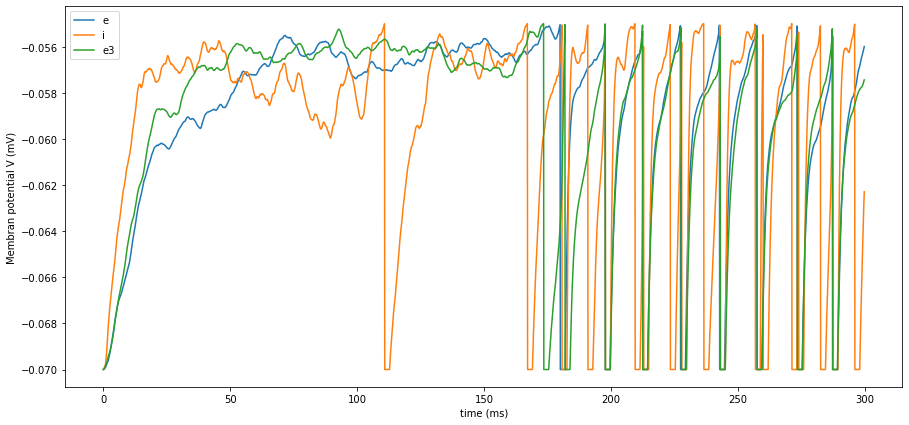

In [26]:
#We want to plot the membrane potential of 2 example neurons. 
#1 inhibitory and 1 exitatory
fig2 = plt.figure(figsize=(15,7))
plot(mE.t/ms,mE.v[0],label='e') #I am plotting only the first excitatory neuron v[0]. 
plot(mI.t/ms,mI.v[0],label='i') #I am plotting only the first excitatory neuron.
#ADD the plot of the membrane of the 3rd excitatory neuron  
#Answer:

#Solution: 
plot(mE.t/ms,mE.v[2],label='e3') #3rd neuron

xlabel('time (ms)')
ylabel('Membran potential V (mV)')
legend()
show()

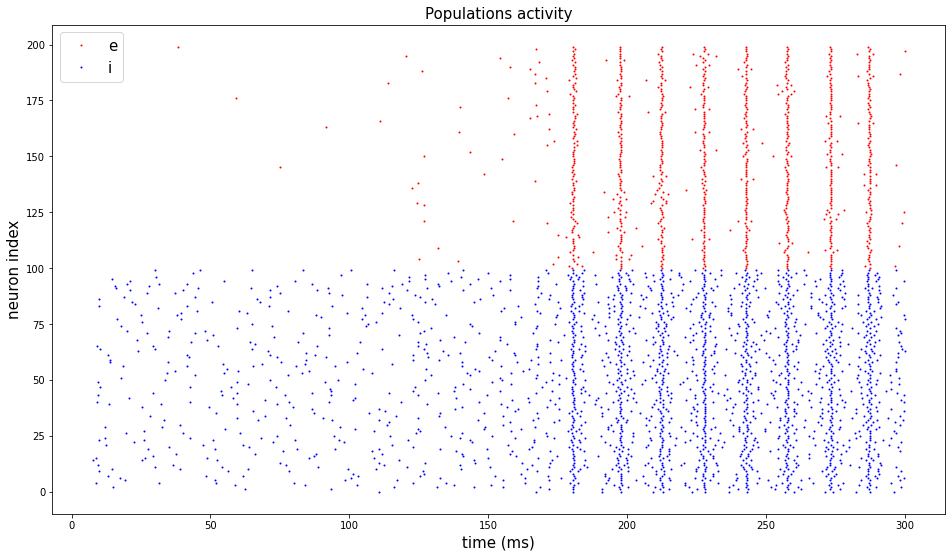

In [43]:
#TO visualize the spikes of the neurons we use a raster plot.
import pylab
f= plt.figure(figsize=(16,9))
plot(S_e.t/ms,S_e.i+ n_activity,'.', markersize=2,color='r', label='e')
plot(S_i.t/ms,S_i.i,'.', markersize=2,color='b', label='i')
xlabel('time (ms)', size=15)
ylabel('neuron index',size=15)
legend(prop={'size': 15})
plt.title('Populations activity',size=15)
plt.savefig('image_sync')
pylab.savefig('Imag.png')
#print(S_e.t)

Why the excitatory neuron are not spiking? \
What can we change in the model to allow them to spike? \
(Hint: think about the external input, the strenght of connections between the populations )

Try to change the code and see if you are able to have a response of the excitatory population. Save the plots.


In [12]:
#Answer:
#The inhibition is too strong! They can't fire because of that. 

Increase the size of your network (by changing the number of neuron in each population). Record from a higher number of neurons (n_activity). 
Run the code again

In [13]:
#Answer: 

# LFP simulation

In experiments is possible to measure the local field potential in the neuronal tissue. \
This gives us a measure of the activity of that region in the brain. The electrodes can record from many different neurons. \
Are you familiar with LFP? Do a brief search online about this tecnique. 

How can we simulate a local field potential recording in a computational model? 

In this paper https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004584 
they suggest a way to approximate the LFP starting from the output of a LIF network.

The formula they suggest is: 
    $$ LFP(r,d,t)=norm[\sum_{pyr}I_{AMPA}(t-τ_1)- \alpha \sum_{pyr}I_{GABA}(t-τ_2)] $$
    where for semplicity in the following we chose $τ_1=τ_2=0$ and $\alpha=1$.

During the simulation using \
iampaE=StateMonitor(popE, 'I_AMPA_rec',record=True) \
igabaE=StateMonitor(popE, 'I_GABA',record=True) \
we have recorded for all the neurons the ampa and gaba current at each time step.
iampaE contains 1 array for each neuron. \
We have everything we need to compute the LFP, let's proceede!

In [17]:
t_sim=300
total_steps=t_sim/0.1
#We create an empty array which will contain (after the calculation) the sum of all the arrays for Igaba (1 foe each neuron).
gaba_all=[0 for i in range(0,int(total_steps))]
#We create an empty array which will contain (after the calculation) the sum of all the arrays for Iampa.
ampa_all=[0 for i in range(0,int(total_steps))]

for i in range(0,NE):
    gaba_all+=np.array(-igabaE.I_GABA[i]/pA) #I sum all the Igaba, I have one for each neuron.
    #Do the same for ampa_all
    #Answer:
    
    #Solution:
    ampa_all+=np.array(-iampaE.I_AMPA_rec[i]/pA)
    
#print(gaba_all)
#print(ampa_all)

#Now compute the LFP using the Formula (we already have the sum over Iampa and over Igaba)

#Answer: 

#Solution:
LFP_array=ampa_all - 1*gaba_all
print(LFP_array)


#Compute STD (because we need to normalize it)
std_LFP=statistics.stdev(LFP_array)

LFP_array_norm= LFP_array/std_LFP
#To check that we normalized correctly:
# std_LFPnorm=statistics.stdev(LFP_array_norm)
# print(std_LFPnorm) #it should be one

[   0.            0.            0.         ... 5149.33464742 5180.1975684
 5197.28983991]


We want to visualize the currents. 

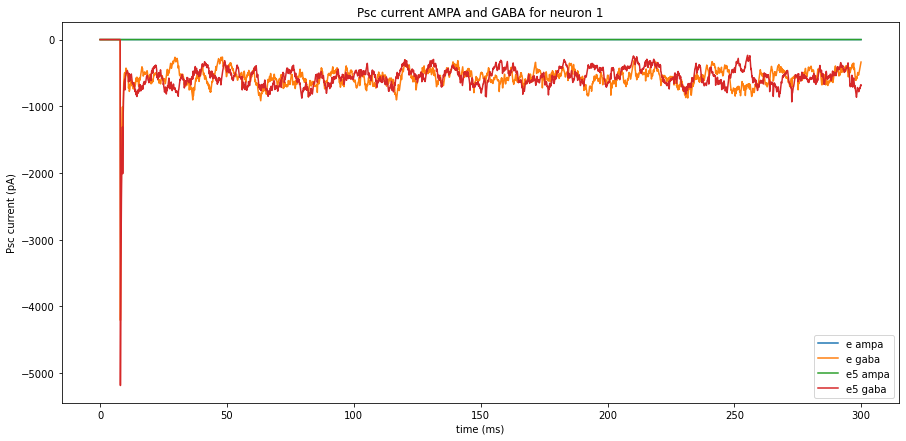

In [18]:
#Let's look at the GABA and AMPA current that the first neuron is receiving
fig2 = plt.figure(figsize=(15,7)) #Create the fig
plot(iampaE.t/ms,-iampaE.I_AMPA_rec[0]/pA,label='e ampa')  
#I divide it by pA and ms to have adimentional measure. 
#iampaE.t are the time steps, iampeE.I_AMPA_rec contains the AMPA current values for all the neurons (at each time step)
#[0] indicate that I am plotting the Iampa of only the 1st neuron
plot(igabaE.t/ms,-igabaE.I_GABA[0]/pA,label='e gaba')
#print(-iampaE.I_AMPA_rec[0])
#Can you add the currents of neuron 5 to the plot? 
#Answer:

#Solution: 
plot(iampaE.t/ms,-iampaE.I_AMPA_rec[5]/pA,label='e5 ampa')  
plot(igabaE.t/ms,-igabaE.I_GABA[5]/pA,label='e5 gaba')

xlabel('time (ms)')
ylabel('Psc current (pA)')
title('Psc current AMPA and GABA for neuron 1')
legend()
show()




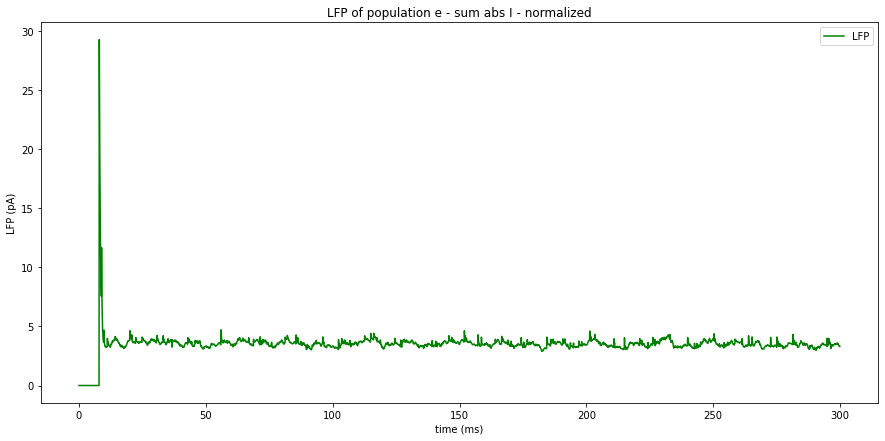

In [19]:
#Now let's plot the LFP we computed 
fig3 = plt.figure(figsize=(15,7))
#You need to plot the value of the LFP at each time step, 
#you already have the array LFP_array_norm, just insert it in a plot!
#Answer:

#Solution: 
plot(iampaE.t/ms,LFP_array_norm,color='green',label='LFP') 
xlabel('time (ms)')
ylabel('LFP (pA)')
title('LFP of population e - sum abs I - normalized')
#xlim(0,100)
legend()
show()

Congratulation you have simulated the LFP signal you measure in your network!

# Conclusions on LFP

How can you make this simultion more realistic?  \
Here we are recording the currents from all the neurons and all the neurons of the network contribute in the same way to the LFP signal. 


How is in reality? Do you think neurons contribute all the same to the signal?


In [ ]:
#Answer: 

The electrode has a spatial position in the brain, the neurons very far contribute less to the signal! 
Think of ways you could take this into account in the simulation. 

In [ ]:
#Answer: 